# Dependencies

In [1]:
!pip install category_encoders

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from category_encoders import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
import math
import statsmodels.api as sm
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from skforecast.recursive import ForecasterRecursive
from sklearn.linear_model import LinearRegression

# Load Dataset

In [3]:
# Load dataset
df = pd.read_csv('input.csv')
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


# Preprocessing

In [4]:
# Drop unnecessary columns
df = df.drop(['UDI'], axis=1)
df = df.drop(['Product ID'], axis=1)
df = df.drop(['Type'], axis=1)
df = df.drop(['Target'], axis=1)
df = df.drop(['Failure Type'], axis=1)
df.columns

Index(['Air temperature [K]', 'Process temperature [K]',
       'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]'],
      dtype='object')

In [5]:
df = df.rename(columns={'Air temperature [K]': 'Air temperature',
                                'Process temperature [K]': 'Process temperature',
                                'Rotational speed [rpm]': 'Rotational speed',
                                'Torque [Nm]': 'Torque',
                                'Tool wear [min]': 'Tool wear',
                                })
df.columns

Index(['Air temperature', 'Process temperature', 'Rotational speed', 'Torque',
       'Tool wear'],
      dtype='object')

# Air temperature Forecasting

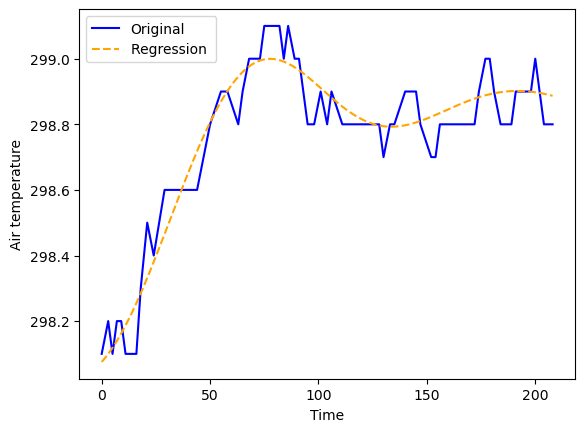

MAE:  0.058196100358117744


In [6]:
df = df.set_index("Tool wear")
full_index = pd.Index(range(df.index.max() + 1), name="Tool wear")
df = df.reindex(full_index)
df["Air temperature"] = df["Air temperature"].interpolate()
df = df.reset_index(drop=True)

x = pd.DataFrame(list(df.index), columns=["Index"])
y = df["Air temperature"]

svr = SVR(kernel='rbf')
svr.fit(x, y)

y_pred = svr.predict(x)

mae = mean_absolute_error(y, y_pred)

plt.plot(y, label='Original', color='blue')
plt.plot(y_pred, label=f'Regression ', linestyle='--', color='orange')

plt.xlabel('Time')
plt.ylabel('Air temperature')
plt.legend()
plt.show()

print("MAE: ", mae)

In [7]:
train_dataset = pd.DataFrame(y_pred, columns=["Air temperature"])

forecaster = ForecasterRecursive(
                 regressor = LinearRegression(),
                 lags      = 1
             )
forecaster.fit(y=train_dataset["Air temperature"])
forecaster

=================== 
ForecasterRecursive 
=================== 
Regressor: LinearRegression 
Lags: [1] 
Window features: None 
Window size: 1 
Series name: Air temperature 
Exogenous included: False 
Exogenous names: None 
Transformer for y: None 
Transformer for exog: None 
Weight function included: False 
Differentiation order: None 
Training range: [0, 208] 
Training index type: RangeIndex 
Training index frequency: 1 
Regressor parameters: 
    {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False} 
fit_kwargs: {} 
Creation date: 2025-10-18 19:53:50 
Last fit date: 2025-10-18 19:53:50 
Skforecast version: 0.18.0 
Python version: 3.12.7 
Forecaster id: None

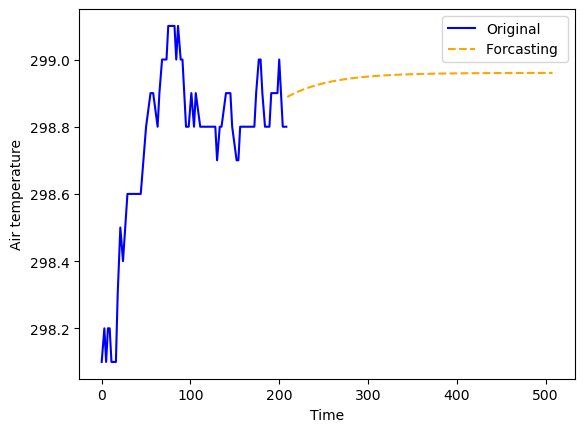

In [8]:
steps = 300
predictions = forecaster.predict(steps=steps)

plt.plot(y, label='Original', color='blue')
plt.plot(predictions, label=f'Forecasting ', linestyle='--', color='orange')

plt.xlabel('Time')
plt.ylabel('Air temperature')
plt.legend()
plt.show()

In [9]:
predictions = predictions.rename('Air temperature')
output_df = pd.DataFrame(predictions)
output_df

,Air temperature
209,298.888402
210,298.889866
211,298.891299
212,298.892704
213,298.894080
...,...
504,298.960149
505,298.960152
506,298.960156
507,298.960159


In [10]:
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#     display(df)

# Process temperature Forecasting

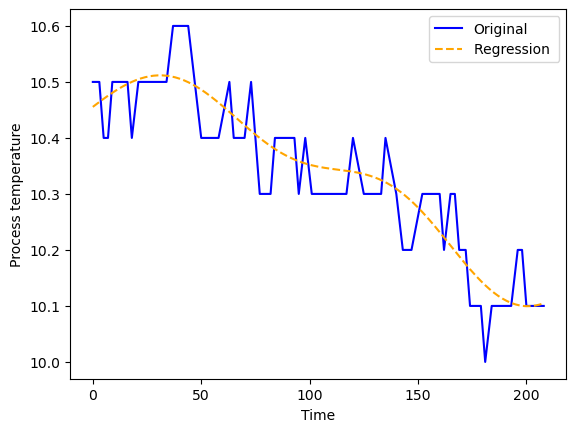

MAE:  0.04205365802339388


In [11]:
process_temperature_ori = df["Process temperature"] - df["Air temperature"]
df["Process temperature"] = process_temperature_ori.interpolate()

x = pd.DataFrame(list(df.index), columns=["Index"])
y = df["Process temperature"]

svr = SVR(kernel='rbf')
svr.fit(x, y)

y_pred = svr.predict(x)

mae = mean_absolute_error(y, y_pred)

plt.plot(y, label='Original', color='blue')
plt.plot(y_pred, label=f'Regression ', linestyle='--', color='orange')

plt.xlabel('Time')
plt.ylabel('Process temperature')
plt.legend()
plt.show()

print("MAE: ", mae)

In [12]:
train_dataset = pd.DataFrame(y_pred, columns=["Process temperature"])

forecaster = ForecasterRecursive(
                 regressor = LinearRegression(),
                 lags      = 1
             )
forecaster.fit(y=train_dataset["Process temperature"])
forecaster

=================== 
ForecasterRecursive 
=================== 
Regressor: LinearRegression 
Lags: [1] 
Window features: None 
Window size: 1 
Series name: Process temperature 
Exogenous included: False 
Exogenous names: None 
Transformer for y: None 
Transformer for exog: None 
Weight function included: False 
Differentiation order: None 
Training range: [0, 208] 
Training index type: RangeIndex 
Training index frequency: 1 
Regressor parameters: 
    {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False} 
fit_kwargs: {} 
Creation date: 2025-10-18 19:53:51 
Last fit date: 2025-10-18 19:53:51 
Skforecast version: 0.18.0 
Python version: 3.12.7 
Forecaster id: None

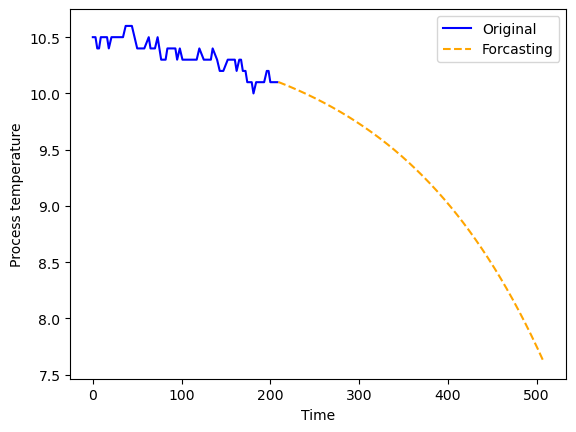

In [13]:
steps = 300
predictions = forecaster.predict(steps=steps)

plt.plot(y, label='Original', color='blue')
plt.plot(predictions, label=f'Forecasting', linestyle='--', color='orange')

plt.xlabel('Time')
plt.ylabel('Process temperature')
plt.legend()
plt.show()

In [14]:
predictions = predictions.values + output_df["Air temperature"].values
predictions = pd.Series(predictions, name='Process temperature', index=output_df.index)
output_df = pd.concat([output_df, predictions], axis=1)
output_df

,Air temperature,Process temperature
209,298.888402,308.990056
210,298.889866,308.988428
211,298.891299,308.986753
212,298.892704,308.985030
213,298.894080,308.983261
...,...,...
504,298.960149,306.643502
505,298.960152,306.626302
506,298.960156,306.609001
507,298.960159,306.591599


# Rotational speed Forecasting

In [15]:
df["Rotational speed"] = df["Rotational speed"].interpolate()
y = df["Rotational speed"]

df["Rotational speed"]

0      1551.000000
1      1503.333333
2      1455.666667
3      1408.000000
4      1453.000000
          ...     
204    1379.000000
205    1420.000000
206    1461.000000
207    1458.000000
208    1455.000000
Name: Rotational speed, Length: 209, dtype: float64

In [16]:
train_dataset = df["Rotational speed"]

forecaster = ForecasterRecursive(
                 regressor = LinearRegression(),
                 lags      = 50
             )
forecaster.fit(y=train_dataset)
forecaster

=================== 
ForecasterRecursive 
=================== 
Regressor: LinearRegression 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50] 
Window features: None 
Window size: 50 
Series name: Rotational speed 
Exogenous included: False 
Exogenous names: None 
Transformer for y: None 
Transformer for exog: None 
Weight function included: False 
Differentiation order: None 
Training range: [0, 208] 
Training index type: RangeIndex 
Training index frequency: 1 
Regressor parameters: 
    {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False} 
fit_kwargs: {} 
Creation date: 2025-10-18 19:53:52 
Last fit date: 2025-10-18 19:53:52 
Skforecast version: 0.18.0 
Python version: 3.12.7 
Forecaster id: None

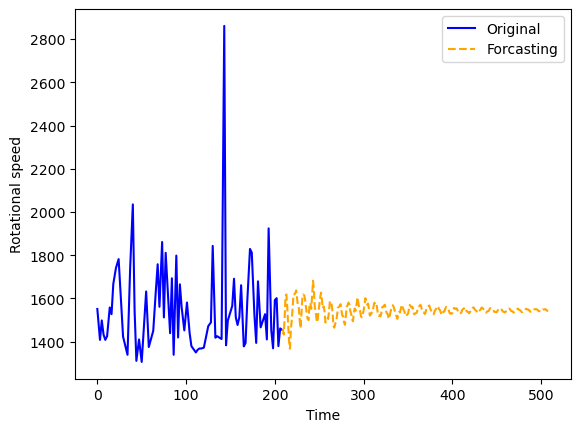

In [17]:
steps = 300
predictions = forecaster.predict(steps=steps)

plt.plot(y, label='Original', color='blue')
plt.plot(predictions, label=f'Forecasting', linestyle='--', color='orange')

plt.xlabel('Time')
plt.ylabel('Rotational speed')
plt.legend()
plt.show()

In [18]:
predictions = predictions.rename('Rotational speed')
output_df = pd.concat([output_df, predictions], axis=1)
output_df

,Air temperature,Process temperature,Rotational speed
209,298.888402,308.990056,1457.902385
210,298.889866,308.988428,1432.781523
211,298.891299,308.986753,1505.982395
212,298.892704,308.985030,1609.737691
213,298.894080,308.983261,1618.235267
...,...,...,...
504,298.960149,306.643502,1549.589441
505,298.960152,306.626302,1550.326896
506,298.960156,306.609001,1545.490208
507,298.960159,306.591599,1542.448737


# Torque Forecasting

In [19]:
df["Torque"] = df["Torque"].interpolate()
y = df["Torque"]

df["Torque"]

0      42.800000
1      43.966667
2      45.133333
3      46.300000
4      47.850000
         ...    
204    46.700000
205    47.300000
206    47.900000
207    44.600000
208    41.300000
Name: Torque, Length: 209, dtype: float64

In [20]:
train_dataset = df["Torque"]

forecaster = ForecasterRecursive(
                 regressor = LinearRegression(),
                 lags      = 50
             )
forecaster.fit(y=train_dataset)
forecaster

=================== 
ForecasterRecursive 
=================== 
Regressor: LinearRegression 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50] 
Window features: None 
Window size: 50 
Series name: Torque 
Exogenous included: False 
Exogenous names: None 
Transformer for y: None 
Transformer for exog: None 
Weight function included: False 
Differentiation order: None 
Training range: [0, 208] 
Training index type: RangeIndex 
Training index frequency: 1 
Regressor parameters: 
    {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False} 
fit_kwargs: {} 
Creation date: 2025-10-18 19:53:54 
Last fit date: 2025-10-18 19:53:54 
Skforecast version: 0.18.0 
Python version: 3.12.7 
Forecaster id: None

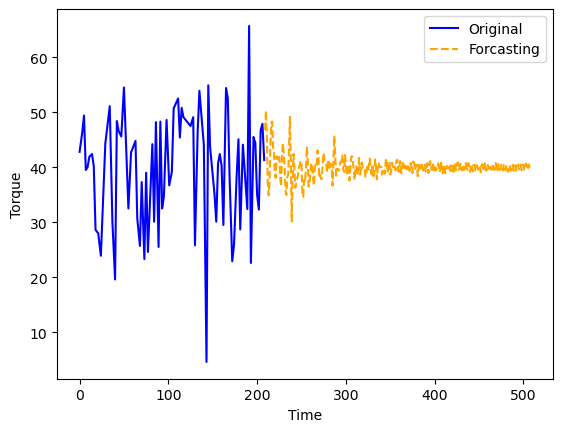

In [21]:
steps = 300
predictions = forecaster.predict(steps=steps)

plt.plot(y, label='Original', color='blue')
plt.plot(predictions, label=f'Forecasting', linestyle='--', color='orange')

plt.xlabel('Time')
plt.ylabel('Torque')
plt.legend()
plt.show()

In [22]:
predictions = predictions.rename('Torque')
output_df = pd.concat([output_df, predictions], axis=1)
output_df

,Air temperature,Process temperature,Rotational speed,Torque
209,298.888402,308.990056,1457.902385,46.733735
210,298.889866,308.988428,1432.781523,50.328962
211,298.891299,308.986753,1505.982395,45.563220
212,298.892704,308.985030,1609.737691,37.102844
213,298.894080,308.983261,1618.235267,34.888968
...,...,...,...,...
504,298.960149,306.643502,1549.589441,39.759907
505,298.960152,306.626302,1550.326896,39.566160
506,298.960156,306.609001,1545.490208,40.509117
507,298.960159,306.591599,1542.448737,40.030169


# Save CSV

In [23]:
indices = list(output_df.index)
indices = pd.Series(indices, name='Tool wear', index=output_df.index)
output_df = pd.concat([output_df, indices], axis=1)
output_df.to_csv('forecaster_output.csv', index=False)